In [507]:
# Import Pandas, Numpy, Matplotlib, and Sqlite3
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from seaborn import plt
from matplotlib.dates import date2num, num2date
import re
import json
import urllib
from datetime import datetime, timedelta
import time

# This enables inline Plots
%matplotlib inline

In [418]:
data_file = 'Medtrack_Deals-MA-Private_21Jan2015.csv'
#Add new column names, initial col names had spaces and slashes
df_cols = ['date', 'category', 'acquirer', 'target', 'value', 'headline']
df = pd.read_csv(data_file, sep=',', names = df_cols)
#Remove initial col names, anything w/o date or value
df = df[1:].dropna(subset=['date', 'value'])
#Replace commas in value and parse number
df['value'] = [float(v.replace(',','')) for v in df.value]
#Check only for values > 500M
df = df[df.value >= 500]
df.reset_index(drop=True, inplace=True)
df.head()

,date,category,acquirer,target,value,headline
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man..."
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...
4,1/1/2015,Majority Acquisition,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,Eli Lilly and Company acquires Novartis Animal...


In [347]:
#df['acquirer'].str.contains(r"\(formerly|\|")

In [419]:
#Drop unnecessary rows for our analysis
df.drop(['category', 'headline'], axis=1, inplace=True)

In [366]:
#function to search yahoo for symbol based on comp name, parse to json, then pull first symbol entry
def name_to_symbol(cname):
    cname = cname.split('(formerly')[0] #use the first name if includes 'formerly company x'
    cname = cname.split('|')[0] #some are separated with pipes, use first
    cname = re.sub('&amp;', '&', cname)
    cname = re.sub('[^A-Za-z0-9&]+', ' ', cname) #include &
    s_name = urllib.quote(cname)
    s_name = re.sub('%20Inc%20', '%20', s_name)
    s_name = re.sub('%20Ltd%20', '%20', s_name)
    url = 'http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={name}&callback=YAHOO.Finance.SymbolSuggest.ssCallback'.format(name = s_name)
    string = urllib.urlopen(url).read()
    string = string.replace('YAHOO.Finance.SymbolSuggest.ssCallback(','')
    string = string[:-1]
    data = json.loads(string)
    result = data['ResultSet']['Result']
    if len(result) == 0:
        symbol = ''
    else:
        symbol = result[0]['symbol']
    return symbol

In [420]:
df['a_symbol'] = map(lambda x: name_to_symbol(x), df.acquirer)
df['t_symbol'] = map(lambda x: name_to_symbol(x), df.target)
df

,date,acquirer,target,value,a_symbol,t_symbol
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,
1,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR
2,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI
3,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,
4,1/1/2015,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,,
5,12/17/2014,Astorg Partners|Montagu Private Equity LLP,SEBIA SA,1747.0,,
6,12/11/2014,Danaher Corporation,Nobel Biocare Holding AG,2200.0,,NBHGF
7,12/1/2014,"Pfizer, Inc.","Baxter International, Inc. - Commercial Vaccin...",635.0,PFE,
8,11/17/2014,Baring Private Equity Asia|The Baring Asia Pri...,Bushu Pharmaceuticals Ltd.,664.9,,
9,11/17/2014,Baring Private Equity Asia|The Baring Asia Pri...,Bushu Pharmaceuticals Ltd.,664.9,,


In [526]:
len(df)

787

In [421]:
print sum(df.t_symbol != '')
print sum(df.a_symbol != '')

64
388


In [422]:
df.head()

,date,acquirer,target,value,a_symbol,t_symbol
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,
1,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR
2,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI
3,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,
4,1/1/2015,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,,


In [423]:
#Only include rows with valid symbol for acquirer
dfaq = df[df.a_symbol != '']
dfaq.reset_index(drop=True, inplace=True)
dfaq.head()

,date,acquirer,target,value,a_symbol,t_symbol
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI
2,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,
3,12/1/2014,"Pfizer, Inc.","Baxter International, Inc. - Commercial Vaccin...",635.0,PFE,
4,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN


In [424]:
#Create separate table for target data
df_target = df[df.t_symbol != '']
df_target.reset_index(drop=True, inplace=True)
df_target.head()

,date,acquirer,target,value,a_symbol,t_symbol
0,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI
2,12/11/2014,Danaher Corporation,Nobel Biocare Holding AG,2200.0,,NBHGF
3,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN
4,10/5/2014,"Becton, Dickinson and Company",CareFusion Corporation,12200.0,,CFN


In [373]:
#Historic S&P 500 Data, pulled from Yahoo API for all years
#Use as a control for stock growth
sp_file = 'sp500.csv'
sp = pd.read_csv(sp_file, sep=',')
ndate=[] #numeric date
for i in range(len(sp)):
    ndate.append(datetime.strptime(sp.Date[i],'%Y-%m-%d'))
sp['ndate'] = ndate
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close,ndate
0,2015-03-13,2064.56,2064.56,2041.17,2053.40,3498560000,2053.40,2015-03-13
1,2015-03-12,2041.10,2066.41,2041.10,2065.95,3405860000,2065.95,2015-03-12
2,2015-03-11,2044.69,2050.08,2039.69,2040.24,3406570000,2040.24,2015-03-11
3,2015-03-10,2076.14,2076.14,2044.16,2044.16,3668900000,2044.16,2015-03-10
4,2015-03-09,2072.25,2083.49,2072.21,2079.43,3349090000,2079.43,2015-03-09


In [441]:
def get_historical_prices(symbol, date):
    """
    Get historical prices for the given ticker symbol.
    First will need to split date on '/'
    
    Returns a json list.
    """
    #Stocks from current date
    m2 = datetime.today().month - 1
    d2 = datetime.today().day
    y2 = datetime.today().year
    
    #Go back to five years before deal
    m, d, y = date.split('/')
    m = str(int(m) - 1)
    d1 = d
    m1 = m
    y1 = str(int(y) - 5)
    
    url = 'http://ichart.yahoo.com/table.csv?s=%s&' % symbol + \
          'd=%s&' % m2 + \
          'e=%s&' % d2 + \
          'f=%s&' % y2 + \
          'g=d&' + \
          'a=%s&' % m1 + \
          'b=%s&' % d1 + \
          'c=%s&' % y1 + \
          'ignore=.csv'
    days = urllib.urlopen(url).readlines()
    #return days
    data = [day[:-2].split(',') for day in days]
    #check data, api unresponsive sometimes, re-run if we get error
    #if it is an error again, likely we don't have data for it, return 0
    error = False
    if data[0][0] != 'Date':
        time.sleep(10)
        days = urllib.urlopen(url).readlines()
        data = [day[:-2].split(',') for day in days]
        if data[0][0] != 'Date':
            error = True
    if error == True:
        data = []
    else:
        data = pd.DataFrame(data = data[1:], columns = data[0])
        ndate=[] #numeric date
        for i in range(len(data)):
            ndate.append(datetime.strptime(data.ix[i, 'Date'],'%Y-%m-%d'))
        data['ndate'] = ndate
    return data

In [375]:
get_historical_prices('0QZM.L', '8/2/2012')

[]

In [442]:
#Sample use of get_historical_prices
sample = get_historical_prices('WGN.DE', '8/2/2012')
sample.head()

,Date,Open,High,Low,Close,Volume,Adj Clos,ndate
0,2014-12-30,62.72,62.72,62.72,62.72,000,62.7,2014-12-30
1,2014-12-29,62.94,63.42,62.94,63.01,400,63.0,2014-12-29
2,2014-12-26,61.20,61.20,61.20,61.20,000,61.2,2014-12-26
3,2014-12-25,61.20,61.20,61.20,61.20,000,61.2,2014-12-25
4,2014-12-24,61.20,61.20,61.20,61.20,000,61.2,2014-12-24


In [443]:
def GrabStockData(x, deal_date, delta):
    #Pull Close value from stock dataframe
    #x is dataframe of stock data
    #delta is the difference in days to use to find historic values
    month, day, year = deal_date.split('/')
    d = datetime(int(year), int(month), int(day)) + timedelta(days = delta)
    if d > x.ix[0, 'ndate']:
        #if date we're looking for is past the latest date
        val = 0
    else:
        val = x[x.ndate == d]
        while len(x[x.ndate == d]) == 0 and (d <= x.ix[0, 'ndate']):
            #If we don't have data for a date take the next date, as long as we're not past max date
            d = d + timedelta(days = 1)
            val = x[x.ndate == d]
        val.reset_index(inplace=True, drop=True)
        val = float(val.ix[0, 'Close'])
    return val

In [ ]:
#def GrabStockData(x, deal_date, delta): saved before making ix alterations
    #Pull Close value from stock dataframe
    #x is dataframe of stock data
    #delta is the difference in days to use to find historic values
    month, day, year = deal_date.split('/')
    d = datetime(int(year), int(month), int(day)) + timedelta(days = delta)
    if d > x.ndate[0]:
        #if date we're looking for is past the latest date
        val = 0
    else:
        val = x[x.ndate == d]
        while len(x[x.ndate == d]) == 0 and (d <= x.ndate[0]):
            #If we don't have data for a date take the next date, as long as we're not past max date
            d = d + timedelta(days = 1)
            val = x[x.ndate == d]
        val.reset_index(inplace=True, drop=True)
        val = float(val.ix[0].Close)
    return val

In [444]:
#Test GrabStockData
symb = 'PFE'
date_used = '03/13/2015'
x = get_historical_prices(symb, date_used)
GrabStockData(x, date_used, 0)

34.0

In [379]:
#Dates for comparison, relative to deal date
#Use these historic dates to compare stock prices before and after deal
Comparison_dates = [0, -183, -365, -730, 183, 365, 730]
#Acquirer and S&P500 data for deal date and before and after 6months, 1year, 2years
Comparison_cols = ['a_deal', 'a_pre_6m', 'a_pre_1y', 'a_pre_2y', 'a_post_6m', 'a_post_1y', 'a_post_2y']
SP_comp_cols = ['sp_deal', 'sp_pre_6m', 'sp_pre_1y', 'sp_pre_2y', 'sp_post_6m', 'sp_post_1y', 'sp_post_2y']

In [380]:
out = []
for i in range(len(Comparison_dates)):
    out.append(GrabStockData(sp, date_used, Comparison_dates[i]))
out

[2053.4, 1997.45, 1846.34, 1554.52, 0, 0, 0]

In [392]:
dfaq.head()

,date,acquirer,target,value,a_symbol,t_symbol
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI
2,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,
3,12/1/2014,"Pfizer, Inc.","Baxter International, Inc. - Commercial Vaccin...",635.0,PFE,
4,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN


In [393]:
#Add relevant stock data for the acquiring company
for j in range(len(Comparison_cols)):
    deal_data = []
    delta = Comparison_dates[j]
    for i in range(len(dfaq)):
        #print i
        symb = dfaq.a_symbol[i]
        #print symb
        date = dfaq.date[i]
        x = get_historical_prices(symb, date)
        if len(x) == 0:
            deal_data.append(0)
        else:
            deal_data.append(GrabStockData(x, date, delta))
    dfaq[Comparison_cols[j]] = deal_data
dfaq.head()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,acquirer,target,value,a_symbol,t_symbol,a_deal,a_pre_6m,a_pre_1y,a_pre_2y,a_post_6m,a_post_1y,a_post_2y
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,,36.51,36.48,69.75,52.97,0,0,0
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI,34.66,37.37,70.83,53.10,0,0,0
2,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,,347.84,319.75,283.67,143.79,0,0,0
3,12/1/2014,"Pfizer, Inc.","Baxter International, Inc. - Commercial Vaccin...",635.0,PFE,,31.26,29.71,31.83,25.09,0,0,0
4,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN,247.94,208.56,162.95,84.99,0,0,0


In [396]:
#Repeat to add S&P500 data around each deal date
for j in range(len(SP_comp_cols)):
    deal_data = []
    delta = Comparison_dates[j]
    for i in range(len(dfaq)):
        #print i
        #symb = df.a_symbol[i]
        #print symb
        date = dfaq.date[i]
        x = sp
        if len(x) == 0:
            deal_data.append(0)
        else:
            deal_data.append(GrabStockData(x, date, delta))
    dfaq[SP_comp_cols[j]] = deal_data
dfaq.head()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,acquirer,target,value,a_symbol,t_symbol,a_deal,a_pre_6m,a_pre_1y,a_pre_2y,a_post_6m,a_post_1y,a_post_2y,sp_deal,sp_pre_6m,sp_pre_1y,sp_pre_2y,sp_post_6m,sp_post_1y,sp_post_2y
0,1/16/2015,"Roche Holding, Ltd.",Trophos SA,550.7,RHHBY,,36.51,36.48,69.75,52.97,0,0,0,2019.42,1958.12,1845.89,1472.63,0,0,0
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI,34.66,37.37,70.83,53.10,0,0,0,2028.26,1977.10,1819.20,1470.68,0,0,0
2,1/11/2015,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,BIIB,,347.84,319.75,283.67,143.79,0,0,0,2028.26,1977.10,1819.20,1472.05,0,0,0
3,12/1/2014,"Pfizer, Inc.","Baxter International, Inc. - Commercial Vaccin...",635.0,PFE,,31.26,29.71,31.83,25.09,0,0,0,2053.44,1924.97,1800.90,1409.46,0,0,0
4,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN,247.94,208.56,162.95,84.99,0,0,0,2041.32,1885.08,1791.53,1386.89,0,0,0


In [397]:
#data for the acquirer post deal
a_post_cols = Comparison_cols[4:7]
a_post_data = dfaq[a_post_cols]
a_post_data.head()

,a_post_6m,a_post_1y,a_post_2y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [398]:
for y in Comparison_cols[1:]:
    print 'pre' in y

True
True
True
False
False
False


In [399]:
#Growth of acquirer at different windows
a_growth_data = pd.DataFrame()
zerovals = dfaq[Comparison_cols[0]] #value at date of deal
a_growth_cols = Comparison_cols[1:] 
for y in a_growth_cols:
    comp_vals = dfaq[y] #value at historic date for comparison
    data = []
    for i in range(len(dfaq)):
        if 'pre' in y:
            if comp_vals[i] == 0:
                val = 0
            else:
                val = (zerovals[i] - comp_vals[i])/comp_vals[i]
        else:
            if zerovals[i] == 0:
                val = 0
            else:
                val = (comp_vals[i] - zerovals[i])/zerovals[i]
        data.append(val)
    a_growth_data[y] = data
a_growth_data.head()

,a_pre_6m,a_pre_1y,a_pre_2y,a_post_6m,a_post_1y,a_post_2y
0,0.000822,-0.476559,-0.310742,-1,-1,-1
1,-0.072518,-0.510659,-0.347269,-1,-1,-1
2,0.087850,0.226214,1.419083,-1,-1,-1
3,0.052171,-0.017908,0.245915,-1,-1,-1
4,0.188819,0.521571,1.917284,-1,-1,-1


In [400]:
#Growth of S&P500 at different windows
sp_growth_data = pd.DataFrame()
zerovals = dfaq[SP_comp_cols[0]] #value at date of deal
sp_growth_cols = SP_comp_cols[1:]
for y in sp_growth_cols:
    comp_vals = dfaq[y] #value at historic date for comparison
    data = []
    for i in range(len(dfaq)):
        if 'pre' in y:
            if comp_vals[i] == 0:
                val = 0
            else:
                val = (zerovals[i] - comp_vals[i])/comp_vals[i]
        else:
            if zerovals[i] == 0:
                val = 0
            else:
                val = (comp_vals[i] - zerovals[i])/zerovals[i]     
        data.append(val)
    sp_growth_data[y] = data
sp_growth_data.head()

,sp_pre_6m,sp_pre_1y,sp_pre_2y,sp_post_6m,sp_post_1y,sp_post_2y
0,0.031306,0.094009,0.371302,-1,-1,-1
1,0.025876,0.114919,0.379131,-1,-1,-1
2,0.025876,0.114919,0.377847,-1,-1,-1
3,0.066739,0.140230,0.456898,-1,-1,-1
4,0.082882,0.139428,0.471869,-1,-1,-1


In [401]:
#Find the difference between the growth over the different intervals and the S&P500 growth
compare_data = pd.DataFrame()
comp_cols = ['pre_6m', 'pre_1y', 'pre_2y', 'post_6m', 'post_1y', 'post_2y']
for j in range(len(comp_cols)):
    data = []
    spvals = sp_growth_data[sp_growth_cols[j]]
    avals = a_growth_data[a_growth_cols[j]] 
    for i in range(len(dfaq)):
        val = avals[i] - spvals[i]
        data.append(val)
    compare_data[comp_cols[j]] = data
compare_data.head()

,pre_6m,pre_1y,pre_2y,post_6m,post_1y,post_2y
0,-0.030483,-0.570568,-0.682044,0,0,0
1,-0.098394,-0.625578,-0.726400,0,0,0
2,0.061974,0.111295,1.041236,0,0,0
3,-0.014568,-0.158138,-0.210984,0,0,0
4,0.105936,0.382143,1.445416,0,0,0


In [402]:
#Find difference between pre and post deal growth
compare_final = pd.DataFrame()
for j in range(len(a_post_cols)):
    acq_data = a_post_data[a_post_cols[j]]
    compare_post = compare_data[comp_cols[j + 3]]
    compare_pre = compare_data[comp_cols[j]]
    data = []
    for i in range(len(a_post_data)):
        #If there's no acquirer data for the given time, mark as nan, else it's the difference between pre and post growth
        if acq_data[i] == 0:
            val = float('nan')
        else:    
            val = compare_post[i] - compare_pre[i]
        data.append(val)
    compare_final[comp_cols[j]] = data
compare_final.head()

,pre_6m,pre_1y,pre_2y
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [405]:
compare_final.describe()

,pre_6m,pre_1y,pre_2y
count,360.000000,336.000000,306.000000
mean,-0.018231,-0.025487,-0.054184
std,0.303232,0.439181,0.638392
min,-1.186457,-1.335197,-2.683980
25%,-0.161699,-0.258652,-0.410791
50%,-0.006849,-0.012414,-0.009678
75%,0.148846,0.199233,0.352071
max,1.921434,2.346289,3.036461


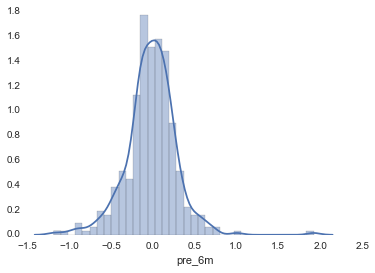

In [508]:
#Difference of relative growth, 6m before and after deal
sixmonths = compare_final.dropna(subset = ['pre_6m'])

#sixmonths.pre_6m.hist(bins = 25)
sns.distplot(sixmonths.pre_6m)


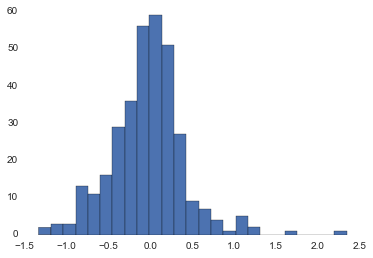

In [406]:
#Difference of relative growth, 1y before and after deal
oneyear = compare_final.dropna(subset = ['pre_1y'])
oneyear.pre_1y.hist(bins = 25)

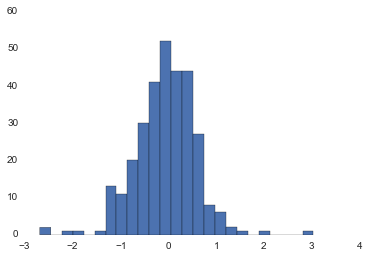

In [407]:
#Difference of relative growth, 2y before and after deal
twoyear = compare_final.dropna(subset = ['pre_2y'])
twoyear.pre_2y.hist(bins = 25)

In [408]:
#Add value column
compare_final['value'] = df.value
compare_final.head()

,pre_6m,pre_1y,pre_2y,value
0,NaN,NaN,NaN,550.7
1,NaN,NaN,NaN,1495.2
2,NaN,NaN,NaN,780.0
3,NaN,NaN,NaN,675.0
4,NaN,NaN,NaN,5400.0


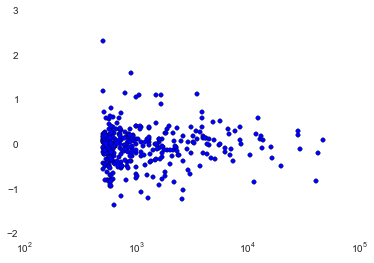

In [522]:
#plt.scatter(compare_final.value, compare_final.pre_6m)
plt.scatter(compare_final.value, compare_final.pre_1y)
#plt.scatter(compare_final.value, compare_final.pre_2y)
#plt.yscale('log')
plt.xscale('log')

In [445]:
#Perform same analysis on target company
Target_cols = map(lambda x: re.sub('a_', 't_', x), Comparison_cols[0:4])

for j in range(len(Target_cols)):
    deal_data = []
    delta = Comparison_dates[j]
    for i in range(len(df_target)):
        #print i
        symb = df_target.ix[i, 't_symbol']
        #print symb
        date = df_target.ix[i, 'date']
        x = get_historical_prices(symb, date)
        if len(x) == 0:
            deal_data.append(0)
        else:
            deal_data.append(GrabStockData(x, date, delta))
    df_target[Target_cols[j]] = deal_data
df_target.head()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,acquirer,target,value,a_symbol,t_symbol,t_deal,t_pre_6m,t_pre_1y,t_pre_2y
0,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR,16.96,5.84,3.56,3.16
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI,46.74,27.41,26.86,35.35
2,12/11/2014,Danaher Corporation,Nobel Biocare Holding AG,2200.0,,NBHGF,17.57,15.40,16.96,8.41
3,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN,209.20,159.70,97.02,90.98
4,10/5/2014,"Becton, Dickinson and Company",CareFusion Corporation,12200.0,,CFN,56.75,39.86,37.01,28.61


In [447]:
#Repeat to add S&P500 data around each deal date
for j in range(len(Target_cols)):
    deal_data = []
    delta = Comparison_dates[j]
    for i in range(len(df_target)):
        #print i
        #symb = df.a_symbol[i]
        #print symb
        date = df_target.ix[i, 'date']
        x = sp
        if len(x) == 0:
            deal_data.append(0)
        else:
            deal_data.append(GrabStockData(x, date, delta))
    df_target[SP_comp_cols[j]] = deal_data
df_target.head()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,acquirer,target,value,a_symbol,t_symbol,t_deal,t_pre_6m,t_pre_1y,t_pre_2y,sp_deal,sp_pre_6m,sp_pre_1y,sp_pre_2y
0,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR,16.96,5.84,3.56,3.16,2023.03,1977.10,1819.20,1470.68
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI,46.74,27.41,26.86,35.35,2028.26,1977.10,1819.20,1470.68
2,12/11/2014,Danaher Corporation,Nobel Biocare Holding AG,2200.0,,NBHGF,17.57,15.40,16.96,8.41,2035.33,1943.89,1782.22,1427.84
3,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN,209.20,159.70,97.02,90.98,2041.32,1885.08,1791.53,1386.89
4,10/5/2014,"Becton, Dickinson and Company",CareFusion Corporation,12200.0,,CFN,56.75,39.86,37.01,28.61,1964.82,1845.04,1676.12,1460.93


In [505]:
df_target['ndate'] = map(lambda x: datetime.strptime(x,'%m/%d/%Y'), df_target.date)

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [500]:
#For Target, find difference in relative growth 2y - 1y and 1y to deal
data = []
for tdeal, t1, t2, sdeal, s1, s2 in zip(df_target.t_deal, df_target.t_pre_1y, df_target.t_pre_2y, df_target.sp_deal, df_target.sp_pre_1y, df_target.sp_pre_2y):
    y2growth = ((t1 - t2)/t2 - (s1 - s2)/s2)
    y1growth = ((tdeal - t1)/t1 - (sdeal - s1)/s1)
    inflation = y1growth - y2growth
    data.append(inflation)
df_target['inflation'] = data
df_target.head()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,acquirer,target,value,a_symbol,t_symbol,t_deal,t_pre_6m,t_pre_1y,t_pre_2y,sp_deal,sp_pre_6m,sp_pre_1y,sp_pre_2y,ndate,inflation
0,1/13/2015,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,,AVNR,16.96,5.84,3.56,3.16,2023.03,1977.10,1819.20,1470.68,2015-01-13,3.762398
1,1/12/2015,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,RHHBY,FMI,46.74,27.41,26.86,35.35,2028.26,1977.10,1819.20,1470.68,2015-01-12,1.102364
2,12/11/2014,Danaher Corporation,Nobel Biocare Holding AG,2200.0,,NBHGF,17.57,15.40,16.96,8.41,2035.33,1943.89,1782.22,1427.84,2014-12-11,-0.874506
3,11/17/2014,"Actavis, plc","Allergan, Inc.",66000.0,ACT,AGN,209.20,159.70,97.02,90.98,2041.32,1885.08,1791.53,1386.89,2014-11-17,1.242201
4,10/5/2014,"Becton, Dickinson and Company",CareFusion Corporation,12200.0,,CFN,56.75,39.86,37.01,28.61,1964.82,1845.04,1676.12,1460.93,2014-10-05,0.214819


In [518]:
df_target[['inflation']].describe()

,inflation
count,60.000000
mean,0.548537
std,1.319758
min,-2.542653
25%,-0.031456
50%,0.198337
75%,1.154103
max,5.869229


In [517]:
#set that one huge outlier to the mean
df_target.inflation[df_target.inflation == max(df_target.inflation)] = df_target.inflation.mean()

C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\generic.py:3368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Zach\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

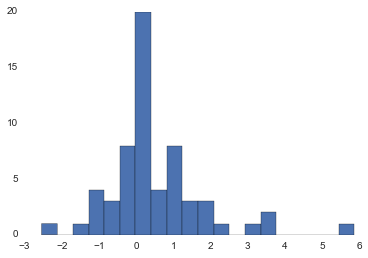

In [519]:
df_target.inflation.hist(bins = 20)

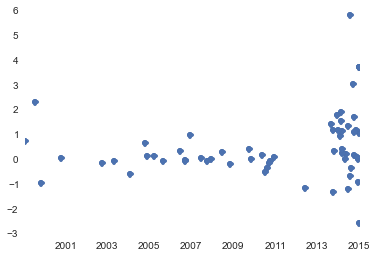

In [521]:
plt.plot(df_target.ndate, df_target.inflation, 'o', )
#plt.yscale('log')

In [24]:
finaldate = datetime(2015,3,15)
finaldate - timedelta(days=365)

datetime.datetime(2014, 3, 15, 0, 0)

In [34]:
y, m, d = x['Date'][i].split('-')

In [86]:
val0 = []
val = []
for i in range(len(df)):
    if df.a_symbol[i] == '':
        start.append('')
        end.append('')
    else:
        data = get_historical_prices(df.a_symbol[i], df.date[i])
        if len(data[0]) == 1:
            start.append('')
            end.append('')
        else:
            start.append(float(data[-1][1]))
            end.append(float(data[1][1]))

In [87]:
df['a_start'] = start
df['a_end'] = end
df.head()

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2


In [53]:
df

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2
5,1/6/2015,Majority Acquisition,Cardio3 BioSciences SA,"OnCyte, LLC",203.0,Cardio3 Biosciences acquires OnCyte from Celda...,2015,CARD.BR,25,36.1
6,1/2/2015,Asset Purchase,Virbac S.A,Eli Lilly and Company - US veterinary assets,410.0,Virbac acquires veterinary assets from Eli Lilly,2015,,,
7,1/1/2015,Majority Acquisition,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,Eli Lilly and Company acquires Novartis Animal...,2015,,,
8,12/18/2014,Majority Acquisition,"Merck &amp; Co., Inc. (formerly Schering-Ploug...",OncoEthix SA,375.0,Merck acquires OncoEthix,2014,,,
9,12/18/2014,Majority Acquisition,"Roche Holding, Ltd.",Dutalys GmbH,488.8,Roche to acquire Dutalys,2014,,,


In [92]:
#Count number of entries
#len(df[df.t_symbol != ''])
#df[df['target'].str.contains(r"\(formerly|\|")]

In [93]:
dif = []
for i in range(len(df)):
    if df.a_start[i] == '':
        dif.append('')
    else:
       dif.append(df.a_end[i] - df.a_start[i])
df['a_dif'] = dif
df.head()

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end,a_dif
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78,50.43
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2,2.44


In [74]:
df_valid = df[df.t_dif != '']
tyeardif = df_valid[['year', 't_dif']].sort('year')

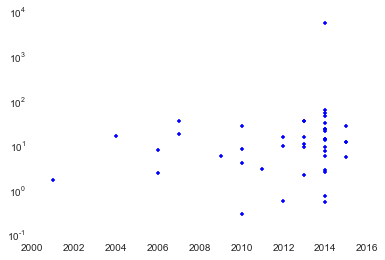

In [78]:
plt.plot(tyeardif.year, tyeardif.t_dif, 'b.')
plt.yscale('log')